In [90]:
%load_ext autoreload
%autoreload 2

import torch
from gpt import GPTModel
from utils import (generate_text_simple, text_to_token_ids, token_ids_to_text, 
                   create_dataloader_v1, train_model_simple,
                   plot_losses, generate)
import tiktoken

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

tokenizer = tiktoken.get_encoding("gpt2")

In [72]:
start_context = "Every effort moves you"

token_ids = generate_text_simple(model, 
                                 text_to_token_ids(start_context, tokenizer),
                                 max_new_tokens=10, 
                                 context_size=GPT_CONFIG_124M["context_length"])
text = token_ids_to_text(token_ids, tokenizer)

In [73]:
text

'Every effort moves you rentingetic minion cones477243 therepo expression syll'

In [74]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [75]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [76]:
train_data = text_data[:int(len(text_data) * 0.9)]
val_data = text_data[int(len(text_data) * 0.9):]

In [77]:
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

In [78]:
x, y = next(iter(train_loader))

In [79]:
x

tensor([[   40,   367,  2885,  1464,  1807,  3619,   402,   271, 10899,  2138,
           257,  7026, 15632,   438,  2016,   257,   922,  5891,  1576,   438,
           568,   340,   373,   645,  1049,  5975,   284,   502,   284,  3285,
           326,    11,   287,   262,  6001,   286,   465, 13476,    11,   339,
           550,  5710,   465, 12036,    11,  6405,   257,  5527, 27075,    11,
           290,  4920,  2241,   287,   257,  4489,    64,   319,   262, 34686,
         41976,    13,   357, 10915,   314,  2138,  1807,   340,   561,   423,
           587, 10598,   393, 28537,  2014,   198,   198,     1,   464,  6001,
           286,   465, 13476,     1,   438,  5562,   373,   644,   262,  1466,
          1444,   340,    13,   314,   460,  3285,  9074,    13, 46606,   536,
          5469,   438, 14363,   938,  4842,  1650,   353,   438,  2934,   489,
          3255,   465, 48422,   540,   450,    67,  3299,    13,   366,  5189,
          1781,   340,   338,  1016,   284,  3758,  

In [87]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model=model, train_loader=train_loader, val_loader=val_loader,
    optimizer=optimizer, device=device, num_epochs=num_epochs,
    eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000):Train loss 9.818 Val loss 9.928
Ep 1 (Step 000005):Train loss 7.919 Val loss 8.335
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010):Train loss 6.584 Val loss 7.043
Ep 2 (Step 000015):Train loss 5.983 Val loss 6.594
Every effort moves you, the, and, the, of the,, the, the. ", the,,, the, and, the,, the, the, the,, the, the,, the, and,,,,, the
Ep 3 (Step 000020):Train loss 15.517 Val loss 15.688
Ep 3 (Step 000025):Train loss 5.602 Val loss 6.455
Every effort moves you, and to the picture. Gis. G, and I had. I had, and I had. Gis, and, and. I had. I had to the his-- the ", and, and--. Gis, and
Ep 4 (Step 000030):Train loss 5.051 Val loss 6.349
Ep 4 (Step 000035):Train loss 4.674 Val loss 6.245
Every effort moves you, and I had a--I was a--I had a of the a of the picture--I--and, I had to me, I had to the picture to the picture to the picture to the picture and I had to me, I
Ep 5 (Step 000040):Train loss 4.127 Val loss 6.304
Ev

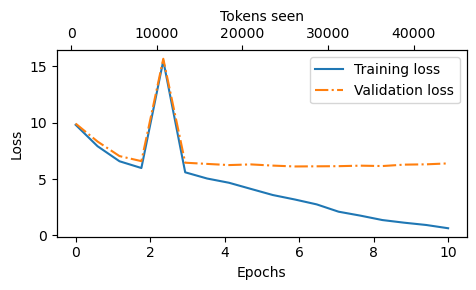

In [88]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [89]:
tokenizer = tiktoken.get_encoding('gpt2')
model.eval()
model.to('cpu')
token_ids = generate_text_simple(model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M['context_length']
)
token_ids_to_text(token_ids=token_ids, tokenizer=tokenizer)

'Every effort moves you?"\n\n"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"\n\n'

In [91]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to happen. It was not it was such not to such not


In [92]:
torch.save(model.state_dict(), "model.pth")

In [93]:
model.state_dict()

OrderedDict([('tok_emb.weight',
              tensor([[ 3.4413e-01, -1.7333e-01, -3.0644e-01,  ..., -3.2659e-01,
                       -1.3876e+00,  5.2208e-01],
                      [ 2.6129e-01,  3.4870e-01, -8.1958e-01,  ..., -4.0895e-01,
                        4.9765e-01, -3.7424e-01],
                      [ 7.9288e-01,  5.3309e-01,  9.3936e-01,  ..., -1.0710e+00,
                        9.5149e-02, -1.4087e+00],
                      ...,
                      [-7.1022e-01, -5.0010e-01,  1.4068e+00,  ..., -1.4925e-01,
                       -4.8801e-01, -1.0582e+00],
                      [ 2.0572e+00,  1.1150e+00,  3.8348e-01,  ..., -7.1757e-01,
                       -5.5503e-01,  9.8285e-01],
                      [ 1.1323e-03, -7.5050e-01, -1.7859e-01,  ..., -3.2327e-01,
                        2.5962e-01,  5.8674e-01]])),
             ('pos_emb.weight',
              tensor([[ 0.8773,  0.2506,  0.8417,  ..., -1.0323,  1.3029,  1.7887],
                      [-1.0013,  0.0